[XEE](https://github.com/google/Xee) is an python package for working with Google Earth Engine data with [XArray](https://docs.xarray.dev/en/stable/). XEE makes it possible to leverage the strengths of both GEE and the Python ecosystem around XArray.

In this section, we will learn how to use XEE to extract and process NDVI time-series using built-in time-series processing function of XArray. Once processed, we will also save the resulting gap-filled images as Cloud-Optimized GeoTIFF (COG) files.

For more examples of integrating XEE in your Python workflows, see the **XEE (XArray + Google Earth Engine)** section of our [Geospatial Python Tutorials](https://www.geopythontutorials.com/).

#### Installation

Let's install the required packages in the Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --upgrade xee
    !pip install rioxarray

In [ ]:
import ee
import xarray as xr
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import os

#### Initialization

First of all, you need to run the following cells to initialize the API and authorize your account. You must have a Google Cloud Project associated with your GEE account. Replace the `cloud_project` with your own project from [Google Cloud Console](https://console.cloud.google.com/).

We are using the [High-volume Endpoint](https://developers.google.com/earth-engine/cloud/highvolume) which supports large number of concurrent requests and is recommended when working with XEE.

In [ ]:
cloud_project = 'spatialthoughts'

try:
    ee.Initialize(
        project=cloud_project,
        opt_url='https://earthengine-highvolume.googleapis.com'
    )
except:
    ee.Authenticate()
    ee.Initialize(
        project=cloud_project,
        opt_url='https://earthengine-highvolume.googleapis.com'
    )

#### Select a location.

In [ ]:
latitude = 27.14240677750266
longitude = 83.10171246528625
point = ee.Geometry.Point([longitude, latitude])

In [ ]:
# Define a 1km bounding box around the chosen point
geometry = point.buffer(1000).bounds()

#### Preprocess the data in GEE

We start with the Sentinel-2 L1C collection. We pre-process the data by applying cloud masking and pixel scaling.

In [ ]:
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

startDate = ee.Date.fromYMD(2019, 1, 1)
endDate = ee.Date.fromYMD(2020, 1, 1)

filtered = s2 \
  .filter(ee.Filter.date(startDate, endDate)) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
  .filter(ee.Filter.bounds(geometry))

# Load the Cloud Score+ collection
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames()

# We need to add Cloud Score + bands to each Sentinel-2
# image in the collection
# This is done using the linkCollection() function
filteredS2WithCs = filtered.linkCollection(csPlus, csPlusBands)

# Function to mask pixels with low CS+ QA scores.
def maskLowQA(image):
  qaBand = 'cs'
  clearThreshold = 0.6
  mask = image.select(qaBand).gte(clearThreshold)
  return image.updateMask(mask)

filteredMasked = filteredS2WithCs \
  .map(maskLowQA)

# Write a function that computes NDVI for an image and adds it as a band
# Create a new image to overcome https://github.com/google/Xee/issues/88
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.multiply(0.0001).addBands(ndvi)\
    .copyProperties(image, ['system:time_start'])

# Map the function over the collection
withNdvi = filteredMasked.map(addNDVI)


#### Load ImageCollection as XArray Dataset

Now we have an ImageCollection that we want to get it as a XArray Dataset. We define the crs, scale and region of interest to extract the ImageCollection using the `ee` engine.

In [ ]:
# XEE needs scale in the units of the CRS
# so if you choose EPSG:4326, the scale needs to be in degrees
crs = 'EPSG:3857'
scale = 10

In [ ]:
ds = xr.open_dataset(
    withNdvi,
    engine='ee',
    crs=crs,
    scale=scale,
    geometry=geometry,
    ee_mask_value=-9999,
)

ds

Select the `ndvi` band.

In [ ]:
ndvi_time_series = ds.ndvi

Run `compute()` to fetch the pixels from Earth Engine. This may take some time depending on the size of the request.

In [ ]:
%%time
ndvi_time_series = ndvi_time_series.compute()

Plot the time-series at the chosen point.

In [ ]:
point_x, point_y = point.transform(crs).coordinates().getInfo()

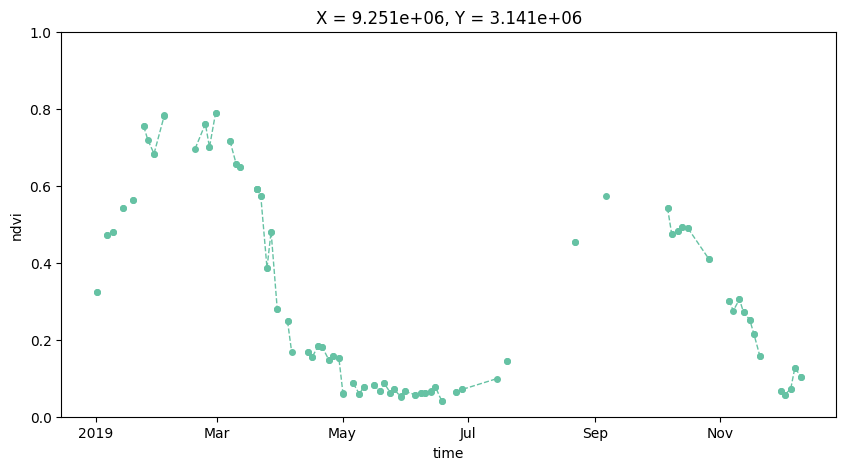

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ndvi_time_series\
  .sel(X=point_x, Y=point_y, method='nearest').plot.line(
    ax=ax, x='time',
    marker='o', color='#66c2a4',
    linestyle='--', linewidth=1, markersize=4)
plt.ylim(0, 1)
plt.show()

#### Process Time-Series using XArray

We use XArray's excellent time-series processing functionality to process the time-series.

* First, we create a regularly spaced time-series using `resample()`
* Next we fill the cloud-masked pixels using `interpolate_na()` from temporal neighbors.
* Finally, we apply a moving-window smoothing using `rolling()` to remove noise.

In [ ]:
%%time
# Group by date and take the mean to handle duplicate dates before resampling
ndvi_time_series_resampled = ndvi_time_series \
  .sortby('time') \
  .resample(time='5D').mean(dim='time')
ndvi_time_series_interpolated = ndvi_time_series_resampled \
  .interpolate_na('time', use_coordinate=False)
ndvi_time_series_smoothed = ndvi_time_series_interpolated \
  .rolling(time=3, center=True).mean()

Plot the original and smoothed time-series.

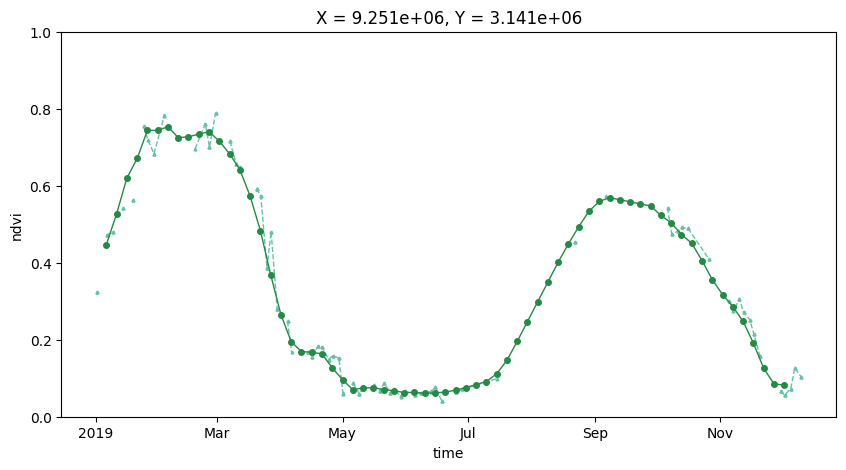

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ndvi_time_series \
  .sel(X=point_x, Y=point_y, method='nearest').plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4',
    linestyle='--', linewidth=1, markersize=2)
ndvi_time_series_smoothed \
  .sel(X=point_x, Y=point_y, method='nearest').plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45',
    linestyle='-', linewidth=1, markersize=4)

plt.ylim(0, 1)
plt.show()

## Download Time-Series Images

Save the output GeoTIFF files to Google Drive if running the notebook from Colab. Otherwise to a local folder.

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  output_folder = '/content/drive/MyDrive/earthengine/'
else:
  output_folder = 'output'

In [ ]:
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Save the original time-series images using `rioxarray` as GeoTIFF files.

In [ ]:
for time in ndvi_time_series.time.values:
  image = ndvi_time_series.sel(time=time)
  # transform the image to suit rioxarray format
  image = image \
    .rename({'Y': 'y', 'X': 'x'}) \
    .transpose('y', 'x') \
    .rio.write_crs(crs)

  date = np.datetime_as_string(time, unit='D')
  output_file = f'ndvi_{date}.tif'
  output_path = os.path.join(output_folder, output_file)
  image.rio.to_raster(output_path, driver='COG')

Save the gap-filled and smoothed time-series images.

In [ ]:
for time in ndvi_time_series_smoothed.time.values:
  image = ndvi_time_series_smoothed.sel(time=time)
  # transform the image to suit rioxarray format
  image = image \
    .rename({'Y': 'y', 'X': 'x'}) \
    .transpose('y', 'x') \
    .rio.write_crs(crs)

  date = np.datetime_as_string(time, unit='D')
  output_file = f'ndvi_smoothed_{date}.tif'
  output_path = os.path.join(output_folder, output_file)
  image.rio.to_raster(output_path, driver='COG')


### Exercise

Replace the `point` with the location of your choice. Extract and download the smoothed time-series.